In [2]:
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, ResNet50, DenseNet121, InceptionV3
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from sklearn.metrics import precision_recall_curve, average_precision_score, accuracy_score
import seaborn as sns
# from transformers import ViTForImageClassification, ViTFeatureExtractor, TFAutoModelForImageClassification
# from transformers import AdamW
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold


/Users/nadunsenarathne/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Extracting frames from the video clips

In [4]:
def extract_frames(video_path, output_folder, player_name, num_frames=15):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Cannot open video file {video_path}")
        return

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    interval = total_frames // num_frames if total_frames > num_frames else 1

    video_basename = os.path.splitext(os.path.basename(video_path))[0]  # Get video file name without extension
    player_folder = os.path.join(output_folder, player_name)

    try:
        if not os.path.exists(player_folder):
            os.makedirs(player_folder)
    except OSError:
        print(f"Error: Creating directory {player_folder}")

    frame_ids = [int(interval * i) for i in range(num_frames)]
    frame_count = 0
    saved_frames = 0

    while saved_frames < num_frames:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_ids[saved_frames])
        success, frame = cap.read()
        if not success:
            print(f"Failed to read frame at index {frame_ids[saved_frames]} from {video_path}")
            saved_frames += 1
            continue

        frame_path = os.path.join(player_folder, f"{video_basename}_frame_{frame_count}.jpg")
        cv2.imwrite(frame_path, frame)
        saved_frames += 1
        frame_count += 1

    cap.release()
    cv2.destroyAllWindows()


## Loading the extracted frames and preprocessing

#### with YOLO

In [4]:
def load_yolo():
    path_to_cfg = "/Users/pubudusenarathne/Downloads/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/yolo/yolov3.cfg" 
    path_to_weights = "/Users/pubudusenarathne/Downloads/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/yolo/yolov3.weights"
    net = cv2.dnn.readNet(path_to_weights, path_to_cfg)
    layers_names = net.getLayerNames()
    
    # Handling different versions of OpenCV which may return different formats
    try:
        output_layers = [layers_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    except Exception:
        output_layers = [layers_names[i - 1] for i in net.getUnconnectedOutLayers()]

    return net, output_layers


def yolo_detect(net, image, output_layers, confidence_threshold=0.3):  # Lowered threshold
    height, width, _ = image.shape
    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    outputs = net.forward(output_layers)
    boxes = []
    confidences = []

    for output in outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > confidence_threshold and class_id == 0:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                if x >= 0 and y >= 0 and (x + w) <= width and (y + h) <= height:
                    boxes.append([x, y, w, h])
                    confidences.append(float(confidence))

    if boxes:
        largest_box = max(boxes, key=lambda b: b[2]*b[3])
        return [largest_box]
    return []


##### without normalization

In [209]:
# def load_and_preprocess_data(root_folder, net, output_layers):
#     images = []
#     labels = []
#     valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tiff")

#     # Create a figure for plotting
#     plt.figure(figsize=(20, 10))
#     image_count = 0  # Counter for current number of plotted images in the figure

#     for player_name in os.listdir(root_folder):
#         player_folder = os.path.join(root_folder, player_name)
#         if os.path.isdir(player_folder):
#             for img_file in os.listdir(player_folder):
#                 if img_file.lower().endswith(valid_extensions):
#                     img_path = os.path.join(player_folder, img_file)
#                     img = cv2.imread(img_path)
#                     if img is None:
#                         print(f"Failed to read image {img_path}.")
#                         continue

#                     boxes = yolo_detect(net, img, output_layers)
#                     if not boxes:
#                         print(f"No valid detections for image {img_path}.")
#                         continue

#                     for box in boxes:
#                         x, y, w, h = box
#                         if x < 0 or y < 0 or x+w > img.shape[1] or y+h > img.shape[0] or w <= 0 or h <= 0:
#                             print(f"Skipping invalid box {box} in image {img_path}.")
#                             continue

#                         cropped_img = img[y:y+h, x:x+w]
#                         resized_img = cv2.resize(cropped_img, (128,128))
#                         images.append(resized_img)
#                         labels.append(player_name)

#                         # Plot each cropped and resized image
#                         if image_count % 25 == 0 and image_count != 0:  # Check if new figure is needed
#                             plt.show()
#                             plt.figure(figsize=(20, 10))

#                         ax = plt.subplot(5, 5, image_count % 25 + 1)  # Use modulo to wrap subplot index
#                         ax.imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
#                         ax.set_title(player_name)
#                         ax.axis('off')
#                         image_count += 1

#     # Show any remaining images
#     if image_count % 25 != 0:
#         plt.show()

#     if not images:
#         raise ValueError("No images processed. Check the dataset and detection steps.")

#     images = np.array(images)
#     labels = np.array(labels)
#     encoder = LabelEncoder()
#     encoded_labels = encoder.fit_transform(labels)
#     categorical_labels = to_categorical(encoded_labels)
    
#     return images, categorical_labels, encoder


##### without normalization and added CLAHE

In [4]:
import numpy as np
import cv2
import os
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

def load_and_preprocess_data(root_folder, net, output_layers):
    images = []
    labels = []
    valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tiff")
    
    # Create an instance of CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    # Create a figure for plotting
    plt.figure(figsize=(40, 20))  # Increased size to accommodate twice as many images per row
    image_count = 0  # Counter for current number of plotted images in the figure

    for player_name in os.listdir(root_folder):
        player_folder = os.path.join(root_folder, player_name)
        if os.path.isdir(player_folder):
            for img_file in os.listdir(player_folder):
                if img_file.lower().endswith(valid_extensions):
                    img_path = os.path.join(player_folder, img_file)
                    img = cv2.imread(img_path)
                    if img is None:
                        print(f"Failed to read image {img_path}.")
                        continue

                    boxes = yolo_detect(net, img, output_layers)
                    if not boxes:
                        print(f"No valid detections for image {img_path}.")
                        continue

                    for box in boxes:
                        x, y, w, h = box
                        if x < 0 or y < 0 or x+w > img.shape[1] or y+h > img.shape[0] or w <= 0 or h <= 0:
                            print(f"Skipping invalid box {box} in image {img_path}.")
                            continue

                        cropped_img = img[y:y+h, x:x+w]
                        resized_img = cv2.resize(cropped_img, (224, 224))

                        # Apply CLAHE
                        lab = cv2.cvtColor(resized_img, cv2.COLOR_BGR2LAB)
                        l, a, b = cv2.split(lab)
                        l = clahe.apply(l)
                        processed_img = cv2.merge([l, a, b])
                        processed_img = cv2.cvtColor(processed_img, cv2.COLOR_LAB2BGR)

                        # # Normalize the image to the range [0, 1]
                        # processed_img = processed_img.astype(np.float32) / 255.0

                        images.append(processed_img)
                        labels.append(player_name)

    #                     # Plot each cropped and resized image
    #                     if image_count % 50 == 0 and image_count != 0:  # Adjusted for two images per player
    #                         plt.show()
    #                         plt.figure(figsize=(40, 20))

    #                     # Original image
    #                     ax = plt.subplot(5, 10, image_count % 50 + 1)  # Use modulo to wrap subplot index
    #                     ax.imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
    #                     ax.set_title(f"Original - {player_name}")
    #                     ax.axis('off')
    #                     image_count += 1

    #                     # CLAHE processed image
    #                     ax = plt.subplot(5, 10, image_count % 50 + 1)
    #                     ax.imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
    #                     ax.set_title(f"CLAHE - {player_name}")
    #                     ax.axis('off')
    #                     image_count += 1

    # # Show any remaining images
    # if image_count % 50 != 0:
    #     plt.show()

    # if not images:
    #     raise ValueError("No images processed. Check the dataset and detection steps.")

    images = np.array(images)
    labels = np.array(labels)
    encoder = LabelEncoder()
    encoded_labels = encoder.fit_transform(labels)
    categorical_labels = to_categorical(encoded_labels)
    
    return images, categorical_labels, encoder


##### Data augmentation

In [211]:
def create_data_augmentation():
    return ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

## Model building and training

### ResNet

In [212]:
def build_model(num_classes):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)  # Adding L2 regularization
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01))(x)  # Adding L2 regularization
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freezing the base layers
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [213]:
# from tensorflow.keras.callbacks import EarlyStopping

# def build_model(num_classes):
#     base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
#     x = base_model.output
#     x = GlobalAveragePooling2D()(x)

#     x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
#     x = Dropout(0.6)(x) 
#     x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
#     x = Dropout(0.6)(x)  
#     x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
#     # x = Dropout(0.6)(x)  

    
#     predictions = Dense(num_classes, activation='softmax')(x)
#     model = Model(inputs=base_model.input, outputs=predictions)

#     # Freezing the base layers
#     for layer in base_model.layers:
#         layer.trainable = False

# # learning rate
# # 0.0002 = 2e-4
# # 0.0001 = 1e-4
# # 0.001 = 1e-3
# # 0.02 = 2e-2

#     model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
#     return model

In [214]:
# from tensorflow.keras.layers import Input, Dense, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dropout
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam

# def identity_block(input_tensor, kernel_size, filters, stage, block):
#     """
#     The identity block is the block that has no conv layer at the shortcut.
#     """
#     filters1, filters2, filters3 = filters
#     bn_axis = 3

#     conv_name_base = 'res' + str(stage) + block + '_branch'
#     bn_name_base = 'bn' + str(stage) + block + '_branch'

#     x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
#     x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
#     x = Activation('relu')(x)

#     x = Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
#     x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
#     x = Activation('relu')(x)

#     x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
#     x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

#     x = Add()([x, input_tensor])
#     x = Activation('relu')(x)
#     return x

# def convolutional_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
#     """
#     Convolutional block that has a conv layer at the shortcut.
#     """
#     filters1, filters2, filters3 = filters
#     bn_axis = 3

#     conv_name_base = 'res' + str(stage) + block + '_branch'
#     bn_name_base = 'bn' + str(stage) + block + '_branch'

#     x = Conv2D(filters1, (1, 1), strides=strides, name=conv_name_base + '2a')(input_tensor)
#     x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
#     x = Activation('relu')(x)

#     x = Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
#     x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
#     x = Activation('relu')(x)

#     x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
#     x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

#     shortcut = Conv2D(filters3, (1, 1), strides=strides, name=conv_name_base + '1')(input_tensor)
#     shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

#     x = Add()([x, shortcut])
#     x = Activation('relu')(x)
#     return x

# def ResNet50(num_classes):
#     input_tensor = Input(shape=(224, 224, 3))

#     x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', name='conv1')(input_tensor)
#     x = BatchNormalization(axis=3, name='bn_conv1')(x)
#     x = Activation('relu')(x)
#     x = MaxPooling2D((3, 3), strides=(2, 2))(x)

#     x = convolutional_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
#     x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
#     x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

#     x = convolutional_block(x, 3, [128, 128, 512], stage=3, block='a')
#     x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
#     x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
#     x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

#     x = convolutional_block(x, 3, [256, 256, 1024], stage=4, block='a')
#     x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
#     x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
#     x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
#     x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
#     x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

#     x = convolutional_block(x, 3, [512, 512, 2048], stage=5, block='a')
#     x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
#     x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

#     x = GlobalAveragePooling2D()(x)
#     x = Dense(256, activation='relu')(x)
#     x = Dropout(0.5)(x)
#     x = Dense(num_classes, activation='softmax')(x)

#     model = Model(input_tensor, x)
#     model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    
#     return model

## Model evaluation

#### normal

In [215]:
def evaluate_model(X_train, y_train, X_test, y_test, model, encoder):

    # Predict the probabilities for the training data
    y_train_probs = model.predict(X_train)
    y_train_pred = np.argmax(y_train_probs, axis=1)
    y_train_true = np.argmax(y_train, axis=1)

    # Predict the probabilities for the test data
    y_probs = model.predict(X_test)
    y_pred = np.argmax(y_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Compute the average precision score
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(len(encoder.classes_)):
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_probs[:, i])
        average_precision[i] = average_precision_score(y_test[:, i], y_probs[:, i])
    
    mAP = np.mean(list(average_precision.values()))
    
    # Generate classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=encoder.classes_))
    
    f1 = f1_score(y_true, y_pred, average='macro')  # You can change 'macro' to 'micro' or 'weighted' depending on your needs
    print("F1 Score (macro-average):", f1)
    print("Train Accuracy:", accuracy_score(y_train_true, y_train_pred))
    print("Test Accuracy:", accuracy_score(y_true, y_pred))
    print("Mean Average Precision (mAP):", mAP)

    # Compute and plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

In [216]:
def plot_history(history):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training vs. Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training vs. Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

def plot_all_histories(all_histories):
    # Assuming each history in all_histories has the same number of epochs
    epochs = range(1, len(all_histories[0].history['loss']) + 1)
    
    plt.figure(figsize=(12, 8))
    
    for i, history in enumerate(all_histories):
        plt.subplot(2, 1, 1)
        plt.plot(epochs, history.history['loss'], label=f'Fold {i+1} Training Loss')
        plt.plot(epochs, history.history['val_loss'], label=f'Fold {i+1} Validation Loss', linestyle='--')
        plt.title('Loss Across Folds')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(2, 1, 2)
        plt.plot(epochs, history.history['accuracy'], label=f'Fold {i+1} Training Accuracy')
        plt.plot(epochs, history.history['val_accuracy'], label=f'Fold {i+1} Validation Accuracy', linestyle='--')
        plt.title('Accuracy Across Folds')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

    plt.tight_layout()
    plt.show()

## Main

#### with YOLO

In [6]:
def main():
    root_folder = '/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/FYP/CricXpert/Datasets/jasprit'
    # net, output_layers = load_yolo()
    output_frame_folder = '/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/FYP/CricXpert/Datasets/extracted_frames'
    video_extensions = ('.mp4', '.avi', '.mov', '.mpeg', '.mpg', '.mkv')

    for player_name in os.listdir(root_folder):
        player_path = os.path.join(root_folder, player_name, 'gait_data')
        if os.path.isdir(player_path):
            print(f"Processing videos for player: {player_name}")
            for video_file in os.listdir(player_path):
                if video_file.endswith(video_extensions):
                    video_path = os.path.join(player_path, video_file)
                    print(f"Extracting frames from: {video_path}")
                    extract_frames(video_path, output_frame_folder, player_name, 20)
                else:
                    print(f"Skipped non-video file: {video_file}")


    # # Load and preprocess data
    # X, y, encoder = load_and_preprocess_data(output_frame_folder, net, output_layers)

    # # Split data into training and testing
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # # # Data augmentation
    # # datagen = create_data_augmentation()

    # # # Build and train model
    # # model = build_model(len(encoder.classes_))    
    # # history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
    # #                     steps_per_epoch=len(X_train) // 32,
    # #                     epochs=30,
    # #                     validation_data=(X_test, y_test))
 

    # # Build and train model
    # model = build_model(len(encoder.classes_))  

    # # Define EarlyStopping callback
    # early_stopping = EarlyStopping(monitor='val_loss',
    #     patience=5,            # Number of epochs with no improvement after which training will be stopped
    #     restore_best_weights=True  # Restore the best model weights obtained during training
    # )

    # history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test),callbacks=[early_stopping])  
    # # history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test))  

    # # Plot training history
    # plot_history(history)

    # # Evaluate the model
    # evaluate_model(X_train, y_train, X_test, y_test, model, encoder)

    # # Save the model and label encoder
    # model.save('ResNet.h5')
    # np.save('label_encoder_classes.npy', encoder.classes_)


if __name__ == "__main__":
    main()

Processing videos for player: Jasprit_Bumrah
Extracting frames from: /Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/FYP/CricXpert/Datasets/jasprit/Jasprit_Bumrah/gait_data/Screen Recording 2024-07-24 at 12.52.03 PM.mov


#### with YOLO and cross validation

Training fold 1...
Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 835ms/step - accuracy: 0.1815 - loss: 7.1588 - val_accuracy: 0.4773 - val_loss: 5.9716
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 782ms/step - accuracy: 0.3487 - loss: 6.2926 - val_accuracy: 0.5985 - val_loss: 5.6724
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 780ms/step - accuracy: 0.4908 - loss: 5.8424 - val_accuracy: 0.6970 - val_loss: 5.4420
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 777ms/step - accuracy: 0.5595 - loss: 5.5476 - val_accuracy: 0.7500 - val_loss: 5.2594
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 770ms/step - accuracy: 0.6292 - loss: 5.3240 - val_accuracy: 0.7803 - val_loss: 5.0969
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 757ms/step - accuracy: 0.6993 - loss: 5.1196 - val_accuracy: 0.7727 - val_loss: 4.9391
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 768ms/step - accuracy: 0.7243 - loss: 4.9873 - val_accuracy: 0.8182 - val_loss: 4.8108
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 759ms/step - accuracy: 0.7895 - loss

<Figure size 4000x2000 with 0 Axes>

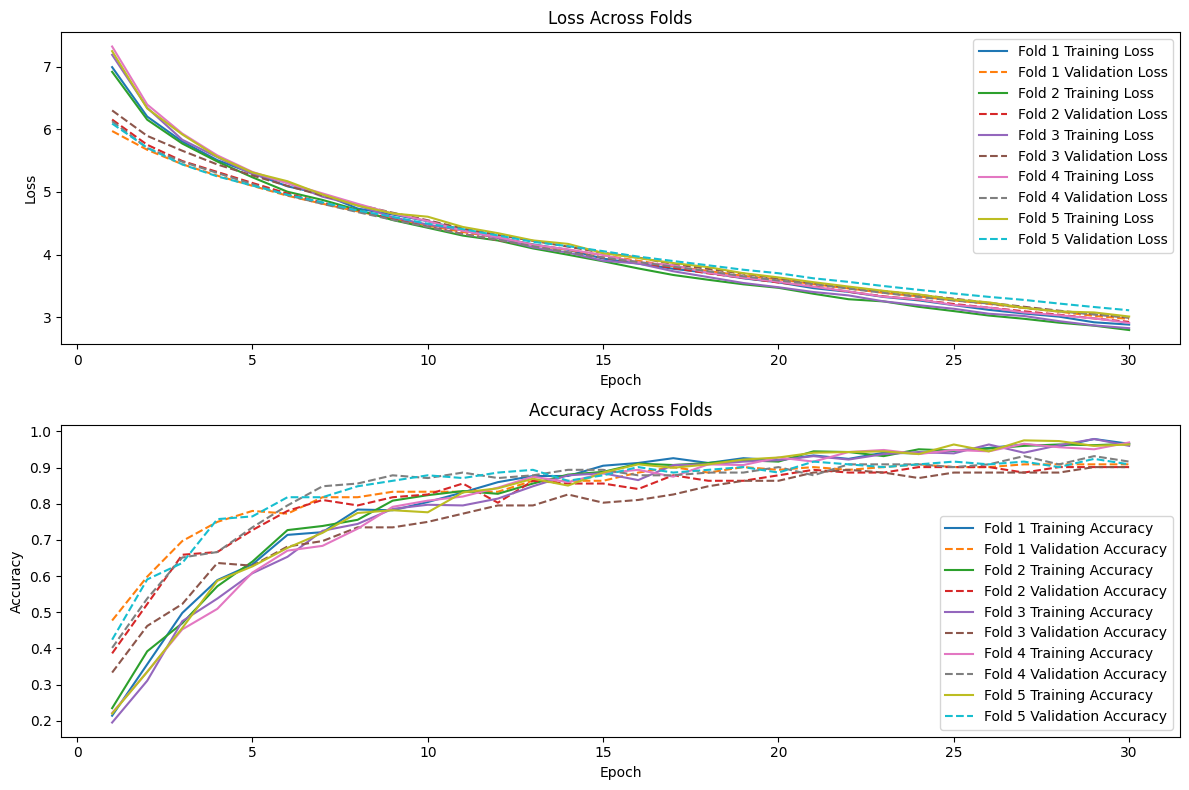

Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 711ms/step - accuracy: 0.1727 - loss: 7.4896 - val_accuracy: 0.4394 - val_loss: 6.0314
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 681ms/step - accuracy: 0.3696 - loss: 6.2330 - val_accuracy: 0.5606 - val_loss: 5.6981
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 676ms/step - accuracy: 0.4884 - loss: 5.7469 - val_accuracy: 0.6364 - val_loss: 5.4414
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 677ms/step - accuracy: 0.5734 - loss: 5.4564 - val_accuracy: 0.6818 - val_loss: 5.2612
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 681ms/step - accuracy: 0.6668 - loss: 5.1981 - val_accuracy: 0.7727 - val_loss: 5.0418
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 675ms/step - accuracy: 0.7424 - loss: 4.9836 - val_accuracy: 0.8182 - val_loss: 4.9082
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 677ms/step - accuracy: 0.7575 - loss: 4.8166 - val_accuracy: 0.8485 - val_loss: 4.7601
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 679ms/step - accuracy: 0.7567 - loss: 4.7291 - val_accu

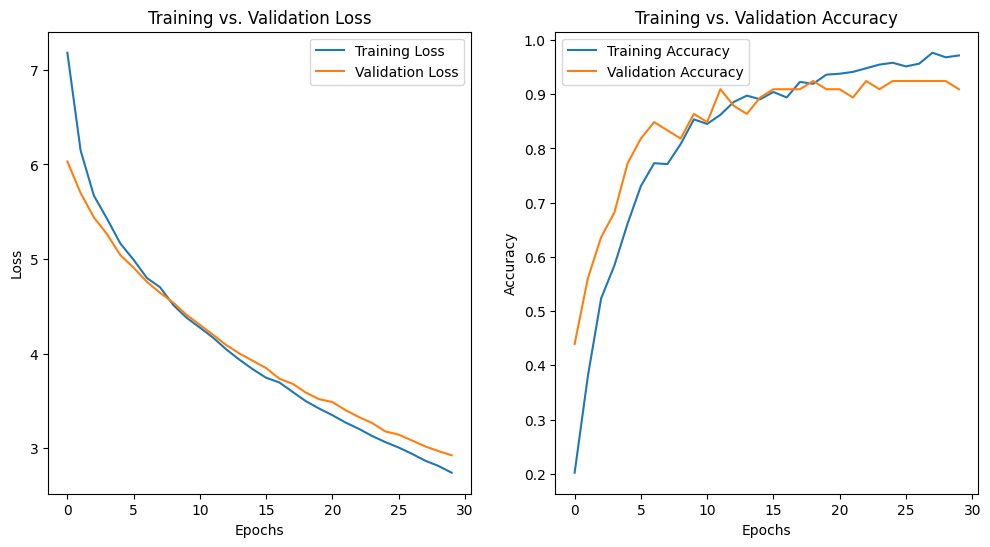

19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 633ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 520ms/step
Classification Report:
                 precision    recall  f1-score   support

 Arshdeep_Singh       0.94      1.00      0.97        30
     Axar_Patel       0.93      0.89      0.91        28
 Jasprit_Bumrah       0.97      1.00      0.98        30
  Kuldeep_Yadav       1.00      1.00      1.00        31
Ravindra_Jadeja       1.00      0.96      0.98        24
    Virat_Kohli       1.00      0.96      0.98        23

       accuracy                           0.97       166
      macro avg       0.97      0.97      0.97       166
   weighted avg       0.97      0.97      0.97       166

F1 Score (macro-average): 0.9694900973308211
Train Accuracy: 1.0
Test Accuracy: 0.9698795180722891
Mean Average Precision (mAP): 0.9906417649610968


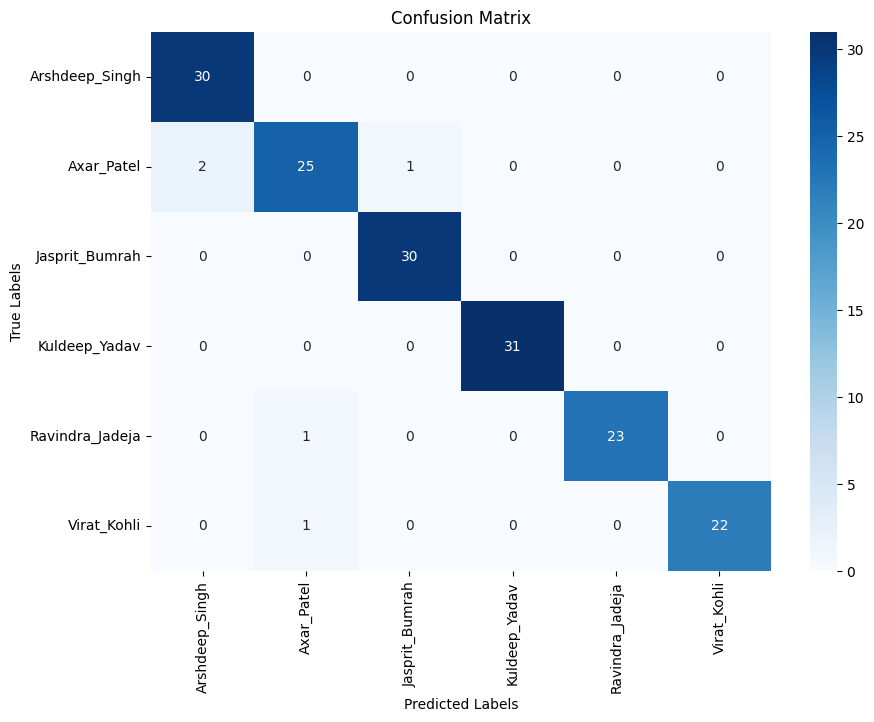

In [354]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from keras.callbacks import EarlyStopping

def main():
    # Loading YOLO network and output layers
    net, output_layers = load_yolo()
    
    # Define output frame folder for processed frames
    output_frame_folder = '/Users/pubudusenarathne/Downloads/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/extracted_frames'

    # Load and preprocess data
    X, y, encoder = load_and_preprocess_data(output_frame_folder, net, output_layers)
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Further split the training data into train and validation sets for final model training
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1, random_state=42)  # 10% validation split

    # Define K-Folds
    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Lists to store metrics across folds
    all_scores = []
    all_histories = []
    fold_var = 1  # Initialize fold counter

    # Train and evaluate the model using Stratified K-Folds
    for train_index, val_index in skf.split(X_train_full, np.argmax(y_train_full, axis=1)):
        X_fold_train, X_fold_val = X_train_full[train_index], X_train_full[val_index]
        y_fold_train, y_fold_val = y_train_full[train_index], y_train_full[val_index]

        # Build and compile the model for each fold
        model = build_model(len(encoder.classes_))

        # Define Early Stopping to prevent overfitting
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        print(f"Training fold {fold_var}...")
        history = model.fit(X_fold_train, y_fold_train, batch_size=32, epochs=30,
                            validation_data=(X_fold_val, y_fold_val), callbacks=[early_stopping])
        
        # Collect history for plotting
        all_histories.append(history)

        # Evaluate the model on the validation set for this fold
        score = model.evaluate(X_fold_val, y_fold_val, verbose=0)
        all_scores.append(score)
        print(f"Score for fold {fold_var}: {model.metrics_names[0]} of {score[0]}; {model.metrics_names[1]} of {score[1]*100}%")

        fold_var += 1  # Increment fold counter after each fold

    # Plot all histories to analyze training and validation dynamics
    plot_all_histories(all_histories)

    # Retrain model on the full training set with explicit validation set
    final_model = build_model(len(encoder.classes_))
    final_history = final_model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_val, y_val))

    # Plot final training and validation history
    plot_history(final_history)

    # Evaluate the fully trained model
    evaluate_model(X_train, y_train, X_test, y_test, final_model, encoder)

    # Save the model and label encoder
    final_model.save('ResNet.h5')
    np.save('label_encoder_classes.npy', encoder.classes_)

if __name__ == "__main__":
    main()


## Inference

#### with YOLO

In [382]:
import cv2
import numpy as np
import os
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
import clahe

# Create an instance of CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

def extract_frames_for_prediction(video_path, output_folder, net, output_layers, num_frames=10):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    interval = total_frames // num_frames if total_frames > num_frames else 1
    frame_ids = [int(interval * i) for i in range(num_frames)]
    frames = []

    try:
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
    except OSError:
        print(f"Error: Creating directory {output_folder}")

    frame_count = 0
    while frame_count < total_frames:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count in frame_ids:
            # Apply YOLO detection to each frame
            boxes = yolo_detect(net, frame, output_layers)
            if boxes:  # Check if there is at least one detection
                x, y, w, h = boxes[0]  # Use the largest detected box 
                cropped_frame = frame[y:y+h, x:x+w]
                resized_frame = cv2.resize(cropped_frame, (224, 224))  # Resize frame

                # Apply CLAHE
                lab = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2LAB)
                l, a, b = cv2.split(lab)
                l = clahe.apply(l)
                processed_img = cv2.merge([l, a, b])
                processed_img = cv2.cvtColor(processed_img, cv2.COLOR_LAB2BGR)

                frames.append(processed_img)
            else:
                print(f"No valid detections at frame {frame_count}.")
        frame_count += 1

    cap.release()
    return np.array(frames)

# Load the model and YOLO net
model = load_model('/Users/pubudusenarathne/Downloads/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/saved_models/ResNet/ResNet.h5')
net, output_layers = load_yolo()

# Properly load the LabelEncoder
encoder = LabelEncoder()
encoder.classes_ = np.load('/Users/pubudusenarathne/Downloads/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/saved_models/ResNet/label_encoder_classes.npy', allow_pickle=True)

# Prediction function
def predict_player(video_path):
    frame_folder = 'temp_frames'
    frames = extract_frames_for_prediction(video_path, frame_folder, net, output_layers)
    if frames.size == 0:
        return "No frames to analyze or no valid detections."

    predictions = model.predict(frames)
    predicted_class = np.argmax(np.mean(predictions, axis=0))
    predicted_player = encoder.inverse_transform([predicted_class])[0]  # Translate label index back to player name

    return predicted_player

# Example usage
video_path = '/Users/pubudusenarathne/Downloads/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/test_video/4.mov'  # Path to your test video clip
result = predict_player(video_path)
print(f"The player in the video is: {result}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
The player in the video is: Arshdeep_Singh


### infernce with ocr

In [1]:
import pytesseract

# Specify the path to tesseract executable
pytesseract.pytesseract.tesseract_cmd = ('/opt/homebrew/bin/tesseract')  # Update this path according to your system

# Example player database with both full reference name and jersey name
player_database = {
    "Virat_Kohli": {"name": "VIRAT", "number": "18"},
    "Arshdeep_Singh": {"name": "ARSHDEEP", "number": "2"},
    "Axar_Patel": {"name": "AXAR", "number": "20"},
    "Jasprit_Bumrah": {"name": "JASPRIT", "number": "93"},
    "Kuldeep_Yadav": {"name": "KULDEEP", "number": "23"},
    "Ravindra_Jadeja": {"name": "JADEJA", "number": "8"}
}

In [2]:
def process_frame_for_OCR_text_detection(image):

    # Convert image to RGB for consistent display if originally in BGR
    if image.shape[2] == 3:  # assuming the image has 3 channels
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Original dimensions
    (H, W) = image.shape[:2]

    # Set the new width and height to nearest multiple of 32 for EAST model
    newW = int(W / 32) * 32
    newH = int(H / 32) * 32

    # Resize the image to fit model requirements
    image = cv2.resize(image, (newW, newH))

    # Load the pre-trained EAST text detector model
    model_path = '/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/FYP/CricXpert/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/saved_models/ResNet/frozen_east_text_detection.pb'
    net = cv2.dnn.readNet(model_path)

    # Prepare the image for the model
    blob = cv2.dnn.blobFromImage(image, 1.0, (newW, newH),
                                 (123.68, 116.78, 103.94), swapRB=True, crop=False)
    net.setInput(blob)

    # Layer names for the output layers
    layerNames = [
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"
    ]

    # Forward pass of the model to get output
    (scores, geometry) = net.forward(layerNames)

    # Decode the predictions
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    # Loop over the number of rows
    for y in range(0, numRows):
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        # Loop over the number of columns
        for x in range(0, numCols):
            if scoresData[x] < 0.5:
                continue

            offsetX = x * 4.0
            offsetY = y * 4.0
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    # Apply non-maxima suppression to avoid overlaps
    indices = cv2.dnn.NMSBoxes(rects, confidences, 0.5, 0.4)

    # Plot the figures side by side
    plt.figure(figsize=(18, 12))


    # # Plot original detections
    # plt.subplot(1, 3, 1)
    # plt.imshow(image)
    # for i in indices.flatten():
    #     (startX, startY, endX, endY) = rects[i]
    #     rect = plt.Rectangle((startX, startY), endX - startX, endY - startY, edgecolor='r', facecolor='none')
    #     plt.gca().add_patch(rect)
    # plt.title('Original Detections')
    # plt.axis('off')


    # Plot original detections
    plt.subplot(1, 3, 1)
    plt.imshow(image)

    if len(indices) > 0:
        indices = indices.flatten()  # Ensuring flattening is possible

        # # Plotting and processing detections
        # plt.figure(figsize=(10, 6))

        for i in indices.flatten():
            (startX, startY, endX, endY) = rects[i]
            rect = plt.Rectangle((startX, startY), endX - startX, endY - startY, edgecolor='r', facecolor='none')
            plt.gca().add_patch(rect)
    plt.title('Original Detections')
    plt.axis('off')

    # Plot merged box
    plt.subplot(1, 3, 2)
    plt.imshow(image)

    cropped_img = None

    if len(indices) > 0:
        min_x = max(0, min([rects[i][0] for i in indices]) - 20)
        min_y = max(0, min([rects[i][1] for i in indices]) - 20)
        max_x = min(W, max([rects[i][2] for i in indices]) + 20)
        max_y = min(H, max([rects[i][3] for i in indices]) + 20)

        cropped_img = image[min_y:max_y, min_x:max_x]

        merged_rect = plt.Rectangle((min_x, min_y), max_x - min_x, max_y - min_y, edgecolor='r', facecolor='none')
        plt.gca().add_patch(merged_rect)
        plt.title('Merged Detections with Expanded Box')
    else:
        plt.title('No Detections Found')
    plt.axis('off')

    # Display the cropped area from the merged box
    plt.subplot(1, 3, 3)
    if len(indices) > 0:
        plt.imshow(cropped_img)
        plt.title('Cropped Area from Merged Box')
    else:
        plt.title('No Area to Crop')
    plt.axis('off')

    plt.show()


    # Proceed with text recognition on the cropped image
    if cropped_img is not None:
        # Convert cropped image from RGB to BGR for OpenCV operations
        cropped_img_bgr = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2BGR)
        
        # Convert to grayscale
        gray = cv2.cvtColor(cropped_img_bgr, cv2.COLOR_BGR2GRAY)

        # # Apply thresholding
        # _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

        # Use median blur to remove noise
        blur = cv2.medianBlur(gray, 5)

        # # Resize for better accuracy
        # resized_img = cv2.resize(blur, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

        # Configure parameters for Tesseract
        custom_config = r'--oem 3 --psm 11'
        text = pytesseract.image_to_string(blur, config=custom_config)

        # plotting the preprocessing visualization of the cropped image
        plt.figure(figsize=(12, 10))
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))
        plt.title('Grayscale')

        plt.subplot(1, 3, 2)
        plt.imshow(blur, cmap='gray')
        plt.title('Median Blur')

        # plt.subplot(1, 3, 3)
        # plt.imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
        # plt.title('Resized for OCR')

        plt.show()

        print("Detected text:", text)
    else:
        print("No area was cropped for text recognition.")


In [5]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder

# Create an instance of CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

def extract_and_visualize_frames(video_path, output_folder, net, output_layers, num_frames=10):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    interval = total_frames // num_frames if total_frames > num_frames else 1
    frame_ids = [int(interval * i) for i in range(num_frames)]
    frames = []

    try:
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
    except OSError:
        print(f"Error: Creating directory {output_folder}")

    frame_count = 0
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))  # Adjust subplot grid and size as needed
    fig.suptitle('Selected Frames from the Video')
    ax_flat = axs.flatten()
    
    while frame_count < total_frames:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count in frame_ids:
            # Apply YOLO detection to each frame
            boxes = yolo_detect(net, frame, output_layers)
            if boxes:  # Check if there is at least one detection
                x, y, w, h = boxes[0]  # Use the largest detected box (assuming `yolo_detect` returns such)
                cropped_frame = frame[y:y+h, x:x+w]
                resized_frame = cv2.resize(cropped_frame, (224, 224))  # Resize frame as per training

                # Apply CLAHE
                lab = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2LAB)
                l, a, b = cv2.split(lab)
                l = clahe.apply(l)
                processed_img = cv2.merge([l, a, b])
                processed_img = cv2.cvtColor(processed_img, cv2.COLOR_LAB2BGR)

                frames.append(processed_img)

                # # Plotting the frame
                # ax_idx = frame_ids.index(frame_count)
                # ax_flat[ax_idx].imshow(cv2.cvtColor(cropped_frame, cv2.COLOR_BGR2RGB))
                # ax_flat[ax_idx].set_title(f"Frame {frame_count}")
                # ax_flat[ax_idx].axis('off')

                process_frame_for_OCR_text_detection(cropped_frame)

            else:
                resized_frame = cv2.resize(frame, (224, 224))  # Resize original frame as fallbac
                print(f"No valid detections at frame {frame_count}.")
        frame_count += 1

    cap.release()
    plt.show()
    return np.array(frames)

# Load the model and YOLO net
model = load_model('/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/FYP/CricXpert/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/saved_models/ResNet/ResNet.h5')
net, output_layers = load_yolo()

# Properly load the LabelEncoder
encoder = LabelEncoder()
encoder.classes_ = np.load('/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/FYP/CricXpert/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/saved_models/ResNet/label_encoder_classes.npy', allow_pickle=True)

# Function to handle frame extraction and visualization by displaying frames
def visualize_frames(video_path):
    frame_folder = 'temp_frames'
    frames = extract_and_visualize_frames(video_path, frame_folder, net, output_layers)
    if frames.size == 0:
        print("No frames to analyze or no valid detections.")

# Example usage
video_path = '/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/FYP/CricXpert/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/test_video/3.mov'  # Path to your test video clip
visualize_frames(video_path)


error: OpenCV(4.10.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/dnn/src/darknet/darknet_importer.cpp:210: error: (-212:Parsing error) Failed to open NetParameter file: /Users/pubudusenarathne/Downloads/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/yolo/yolov3.cfg in function 'readNetFromDarknet'


In [297]:
import cv2
import pytesseract
from PIL import Image
import numpy as np

# Load the image
img = cv2.imread('/Users/pubudusenarathne/Downloads/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/saved_models/ResNet/2.png')  # Update this to the path of your downloaded image


# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply thresholding
_, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

# Use median blur to remove noise
blur = cv2.medianBlur(thresh, 5)

# Resize for better accuracy
resized_img = cv2.resize(blur, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

# Configure parameters for Tesseract
custom_config = r'--oem 3 --psm 11'
text = pytesseract.image_to_string(resized_img, config=custom_config)

print("Detected text:", text)


Detected text: JASPRIT

93



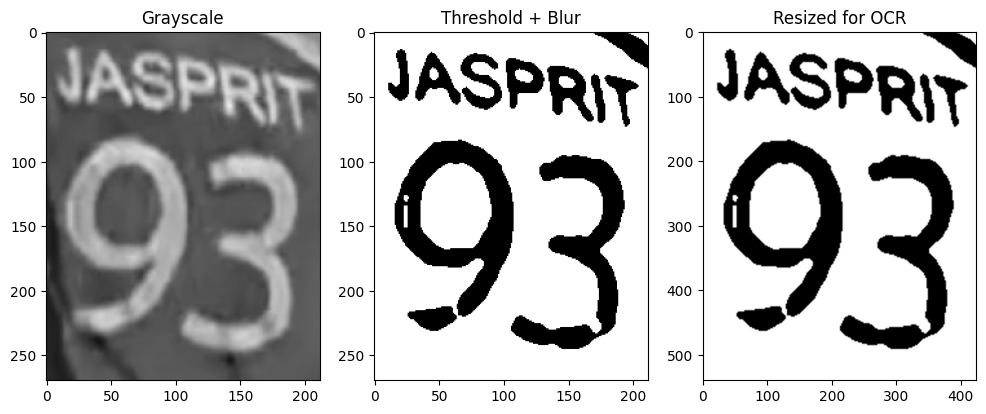

In [298]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))
plt.title('Grayscale')

plt.subplot(1, 3, 2)
plt.imshow(blur, cmap='gray')
plt.title('Threshold + Blur')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
plt.title('Resized for OCR')

plt.show()


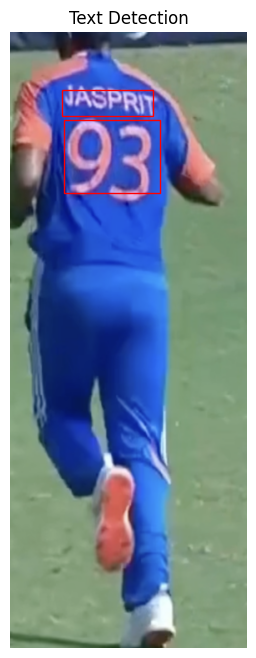

In [301]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def main():
    # Load image
    image_path = '/Users/pubudusenarathne/Downloads/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/saved_models/ResNet/1.png'
    image = cv2.imread(image_path)
    if image is None:
        print("Error loading image")
        return

    # Convert image from BGR to RGB for Matplotlib
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Original dimensions
    (H, W) = image.shape[:2]

    # Set the new width and height to nearest multiple of 32 for EAST model
    newW = int(W / 32) * 32
    newH = int(H / 32) * 32

    # Resize the image to fit model requirements
    image = cv2.resize(image, (newW, newH))

    # Load the pre-trained EAST text detector model
    model_path = '/Users/pubudusenarathne/Downloads/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/saved_models/ResNet/frozen_east_text_detection.pb'
    net = cv2.dnn.readNet(model_path)

    # Prepare the image for the model
    blob = cv2.dnn.blobFromImage(image, 1.0, (newW, newH),
                                 (123.68, 116.78, 103.94), swapRB=True, crop=False)
    net.setInput(blob)

    # Layer names for the output layers
    layerNames = [
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"
    ]

    # Forward pass of the model to get output
    (scores, geometry) = net.forward(layerNames)

    # Decode the predictions
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    # Loop over the number of rows
    for y in range(0, numRows):
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        # Loop over the number of columns
        for x in range(0, numCols):
            if scoresData[x] < 0.5:
                continue

            offsetX = x * 4.0
            offsetY = y * 4.0
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    # Apply non-maxima suppression to avoid overlaps
    indices = cv2.dnn.NMSBoxes(rects, confidences, 0.5, 0.4)

    # Draw bounding boxes
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)
    if len(indices) > 0:
        for i in indices.flatten():
            (startX, startY, endX, endY) = rects[i]
            rect = plt.Rectangle((startX, startY), endX - startX, endY - startY, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
    else:
        print("No text regions detected.")

    ax.set_title('Text Detection')
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    main()


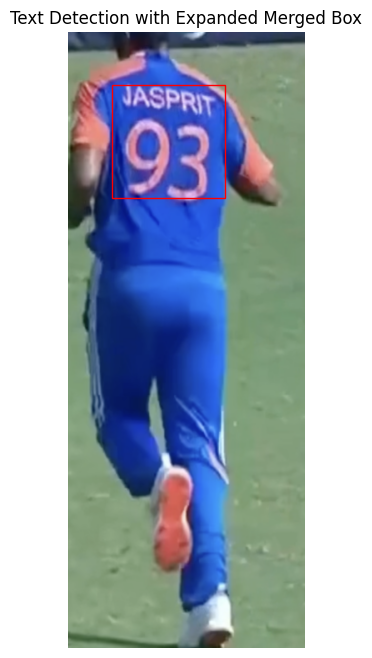

In [265]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def main():
    # Load image
    image_path = '/Users/pubudusenarathne/Downloads/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/saved_models/ResNet/1.png'  # Update path as needed
    image = cv2.imread(image_path)
    if image is None:
        print("Error loading image")
        return

    # Convert image from BGR to RGB for Matplotlib
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Original dimensions
    (H, W) = image.shape[:2]

    # Set the new width and height to nearest multiple of 32 for EAST model
    newW = int(W / 32) * 32
    newH = int(H / 32) * 32

    # Resize the image to fit model requirements
    image = cv2.resize(image, (newW, newH))

    # Load the pre-trained EAST text detector model
    model_path = '/Users/pubudusenarathne/Downloads/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/saved_models/ResNet/frozen_east_text_detection.pb'  # Update path as needed
    net = cv2.dnn.readNet(model_path)

    # Prepare the image for the model
    blob = cv2.dnn.blobFromImage(image, 1.0, (newW, newH),
                                 (123.68, 116.78, 103.94), swapRB=True, crop=False)
    net.setInput(blob)

    # Layer names for the output layers
    layerNames = [
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"
    ]

    # Forward pass of the model to get output
    (scores, geometry) = net.forward(layerNames)

    # Decode the predictions
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    # Loop over the number of rows
    for y in range(0, numRows):
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        # Loop over the number of columns
        for x in range(0, numCols):
            if scoresData[x] < 0.5:
                continue

            offsetX = x * 4.0
            offsetY = y * 4.0
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    # Apply non-maxima suppression to avoid overlaps
    indices = cv2.dnn.NMSBoxes(rects, confidences, 0.5, 0.4)

    # Draw bounding boxes
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)

    if len(indices) > 0:
        # Handle indices correctly depending on their structure
        indices = indices.flatten()  # Ensure indices are a flat array

        # Calculate the min and max coordinates to merge bounding boxes
        margin_horizontal = 15  # Horizontal margin
        margin_vertical = 10   # Vertical margin - increased compared to horizontal
        min_x = max(0, min([rects[i][0] for i in indices]) - margin_horizontal)
        min_y = max(0, min([rects[i][1] for i in indices]) - margin_vertical)
        max_x = min(W, max([rects[i][2] for i in indices]) + margin_horizontal)
        max_y = min(H, max([rects[i][3] for i in indices]) + margin_vertical)

        # Draw the expanded bounding box
        rect = plt.Rectangle((min_x, min_y), max_x - min_x, max_y - min_y, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    else:
        print("No text regions detected.")

    ax.set_title('Text Detection with Expanded Merged Box')
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    main()


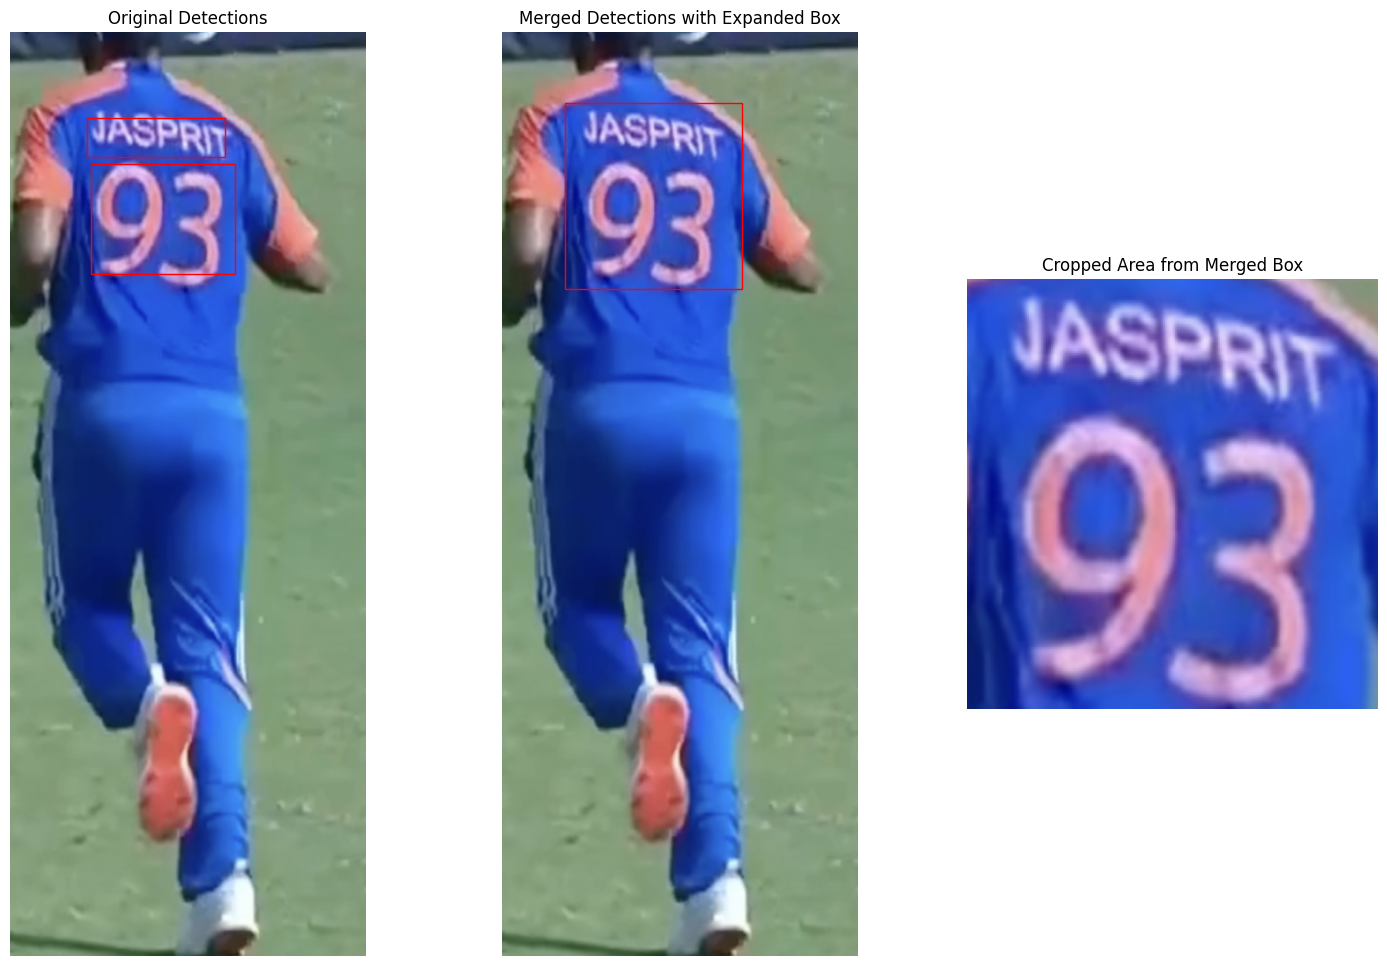

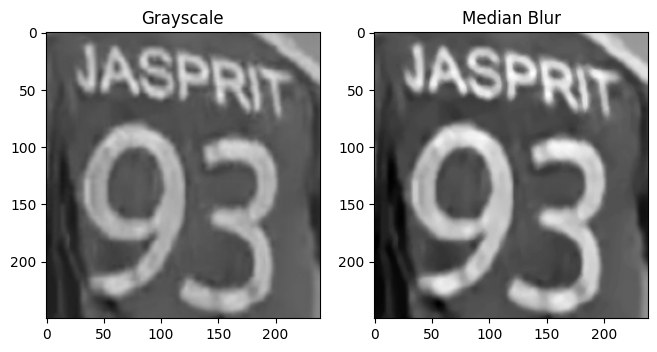

Detected text: 93

ASPRIT



In [353]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def main():
    # Load image
    image_path = '/Users/pubudusenarathne/Downloads/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/saved_models/ResNet/1.png'
    image = cv2.imread(image_path)
    if image is None:
        print("Error loading image")
        return

    # Convert image from BGR to RGB for Matplotlib
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Original dimensions
    (H, W) = image.shape[:2]

    # Set the new width and height to nearest multiple of 32 for EAST model
    newW = int(W / 32) * 32
    newH = int(H / 32) * 32

    # Resize the image to fit model requirements
    image = cv2.resize(image, (newW, newH))

    # Load the pre-trained EAST text detector model
    model_path = '/Users/pubudusenarathne/Downloads/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/saved_models/ResNet/frozen_east_text_detection.pb'
    net = cv2.dnn.readNet(model_path)

    # Prepare the image for the model
    blob = cv2.dnn.blobFromImage(image, 1.0, (newW, newH),
                                 (123.68, 116.78, 103.94), swapRB=True, crop=False)
    net.setInput(blob)

    # Layer names for the output layers
    layerNames = [
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"
    ]

    # Forward pass of the model to get output
    (scores, geometry) = net.forward(layerNames)

    # Decode the predictions
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    # Loop over the number of rows
    for y in range(0, numRows):
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        # Loop over the number of columns
        for x in range(0, numCols):
            if scoresData[x] < 0.5:
                continue

            offsetX = x * 4.0
            offsetY = y * 4.0
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    # Apply non-maxima suppression to avoid overlaps
    indices = cv2.dnn.NMSBoxes(rects, confidences, 0.5, 0.4)

    # Plot the figures side by side
    plt.figure(figsize=(18, 12))

    # Plot original detections
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    for i in indices.flatten():
        (startX, startY, endX, endY) = rects[i]
        rect = plt.Rectangle((startX, startY), endX - startX, endY - startY, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)
    plt.title('Original Detections')
    plt.axis('off')

    # Plot merged box
    plt.subplot(1, 3, 2)
    plt.imshow(image)

    cropped_img = None

    if len(indices) > 0:
        min_x = max(0, min([rects[i][0] for i in indices]) - 20)
        min_y = max(0, min([rects[i][1] for i in indices]) - 20)
        max_x = min(W, max([rects[i][2] for i in indices]) + 20)
        max_y = min(H, max([rects[i][3] for i in indices]) + 20)

        cropped_img = image[min_y:max_y, min_x:max_x]

        merged_rect = plt.Rectangle((min_x, min_y), max_x - min_x, max_y - min_y, edgecolor='r', facecolor='none')
        plt.gca().add_patch(merged_rect)
        plt.title('Merged Detections with Expanded Box')
    else:
        plt.title('No Detections Found')
    plt.axis('off')

    # Display the cropped area from the merged box
    plt.subplot(1, 3, 3)
    if len(indices) > 0:
        plt.imshow(cropped_img)
        plt.title('Cropped Area from Merged Box')
    else:
        plt.title('No Area to Crop')
    plt.axis('off')

    plt.show()


    # Proceed with text recognition on the cropped image
    if cropped_img is not None:
        # Convert cropped image from RGB to BGR for OpenCV operations
        cropped_img_bgr = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2BGR)
        
        # Convert to grayscale
        gray = cv2.cvtColor(cropped_img_bgr, cv2.COLOR_BGR2GRAY)

        # # Apply thresholding
        # _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

        # Use median blur to remove noise
        blur = cv2.medianBlur(gray, 5)

        # # Resize for better accuracy
        # resized_img = cv2.resize(blur, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

        # Configure parameters for Tesseract
        custom_config = r'--oem 3 --psm 11'
        text = pytesseract.image_to_string(blur, config=custom_config)

        # plotting the preprocessing visualization of the cropped image
        plt.figure(figsize=(12, 10))
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))
        plt.title('Grayscale')

        plt.subplot(1, 3, 2)
        plt.imshow(blur, cmap='gray')
        plt.title('Median Blur')

        # plt.subplot(1, 3, 3)
        # plt.imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
        # plt.title('Resized for OCR')

        plt.show()

        print("Detected text:", text)
    else:
        print("No area was cropped for text recognition.")


if __name__ == "__main__":
    main()
